# Data Preprocessing for Image Classification: Cats vs. Dogs

This notebook showcases an extensive workflow for advanced image preprocessing targeted at a binary classification challenge—distinguishing between cats and dogs. Employing robust Python libraries such as OpenCV and PIL, this guide covers several critical preprocessing techniques. These methods are designed to optimize images for machine learning models, incorporating tasks such as noise addition, random cropping, color adjustments, and perspective transformations to enhance data robustness.

## Functions Overview

### 1. `load_images_to_binary`
Loads images from designated subfolders ('train' and 'test') and converts them into a compact binary format. This method is essential for handling large datasets efficiently, particularly in memory-constrained environments. It stores images in binary form along with labels ('cats' or 'dogs') and the dataset category ('train' or 'test').

**Parameters:**
- `base_dir`: The base directory containing the image datasets.
- `subfolder`: Specifies the subfolder ('train' or 'test') from which to load the images.

### 2. `to_grayscale`
Transforms color images to grayscale to simplify the data, beneficial for models that do not rely on color data for effective learning outcomes.

**Parameter:**
- `img_data`: The binary data of the image to convert.

### 3. `apply_median_filter`
Applies a median filter to smooth images by reducing noise. This filter is instrumental in minimizing unnecessary data variations that could affect model accuracy.

**Parameters:**
- `img_data`: The binary image data on which to apply the filter.
- `filter_size`: The dimension of the square filter mask used for the median filter.

### 4. `augment_image`
Enhances the dataset by introducing variability through random image transformations including rotation, shifting, and flipping. Such augmentations are crucial for training robust machine learning models capable of generalizing from varied data inputs.

**Parameter:**
- `img_data`: The binary image data to augment.

### 5. `add_noise`
Injects random noise into images, mimicking real-world imperfections and testing the model's resilience.

**Parameter:**
- `img_data`: The binary data of the image to add noise.

### 6. `random_crop`
Crops random sections of images to force the model to recognize features from partial views.

**Parameter:**
- `img_data`: The binary data of the image to crop randomly.

### 7. `color_jitter`
Randomly adjusts the brightness, contrast, and saturation to prepare the model for various lighting and color conditions.

**Parameter:**
- `img_data`: The binary data of the image for color adjustment.

### 8. `perspective_transformation`
Alters the image perspective, simulating different camera angles and orientations.

**Parameter:**
- `img_data`: The binary data of the image to transform the perspective.

## Execution and Visualization
The notebook applies each preprocessing function to a collection of images stored on Google Drive, showcasing the impact of each transformation through visual comparisons. These steps are illustrated with before-and-after images to highlight the effects of preprocessing techniques on enhancing data quality.

By completing this notebook, you will obtain a diverse and well-prepared dataset, optimized for training a machine learning model to accurately classify images as either cats or dogs.


# Why Use Binary Format?
- **Efficiency**: Binary formats are compact and efficient for storage and transmission because they represent the image data directly without any unnecessary overhead.
- **Speed**: Operations on binary data are generally faster than those on other data formats because they are closer to the hardware level.
- **Interoperability**: Binary data can be easily shared across different systems and software without compatibility issues, assuming the format is understood by the receiving system.

In [34]:
%pip install keras

In [69]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm

In [36]:
base_dir = '/content/drive/MyDrive/Colab Notebooks/Computer Vision Toolbox/data/binaryclass/cats_dogs'

In [70]:
base_dir = '/content/drive/MyDrive/Colab Notebooks/Computer Vision Toolbox/data/binaryclass/cats_dogs'
IMAGE_SIZE = (150, 150)

def load_data(base_path):
    datasets = {'train': [], 'test': []}
    for phase in ['train', 'test']:
        data_path = os.path.join(base_path, phase)
        images, labels = [], []
        print(f"Loading {phase} data...")

        for folder in os.listdir(data_path):
            class_label = 1 if folder.lower() == 'dogs' else 0
            folder_path = os.path.join(data_path, folder)

            for file in tqdm(os.listdir(folder_path)):
                img_path = os.path.join(folder_path, file)
                image = cv2.imread(img_path)
                if image is not None:
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    image = cv2.resize(image, IMAGE_SIZE)
                    images.append(image / 255.0)  # Normalize images to [0, 1]
                    labels.append(class_label)

        datasets[phase].append(np.array(images))
        datasets[phase].append(np.array(labels))

    return datasets['train'][0], datasets['train'][1], datasets['test'][0], datasets['test'][1]

In [71]:
images_train, labels_train, images_test, labels_test = load_data(base_path)

Loading train data...


100%|██████████| 279/279 [00:05<00:00, 47.58it/s]


Loading test data...


100%|██████████| 70/70 [00:01<00:00, 54.78it/s]


In [75]:
# Transformation functions

def to_grayscale(img_data):
    return cv2.cvtColor(img_data, cv2.COLOR_RGB2GRAY)

def apply_median_filter(img_data, filter_size=5):
    return cv2.medianBlur(img_data, filter_size)

def augment_image(img_data):
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    img_data = img_data.reshape((1,) + img_data.shape)  # Reshape to (1, height, width, channels)
    it = datagen.flow(img_data, batch_size=1)
    augmented_image = it.next()[0].astype('uint8')  # Retrieve augmented image and ensure data type
    return augmented_image

def add_noise(img_data):
    if img_data.dtype == np.float32:  # Assuming img_data is in [0, 1]
        # Adding smaller noise for float32 type
        noise = np.random.normal(0, 0.1, img_data.shape)  # Adjust noise level here
        noisy_image = img_data + noise
        noisy_image = np.clip(noisy_image, 0, 1)  # Ensure values stay within [0, 1]
    elif img_data.dtype == np.uint8:  # Assuming img_data is in [0, 255]
        # Adding larger noise for uint8 type
        noise = np.random.normal(0, 25, img_data.shape)  # Adjust noise level here
        noisy_image = img_data.astype(np.float32) + noise
        noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)  # Ensure values stay within [0, 255]
    return noisy_image

def random_crop(img_data, crop_size=(100, 100)):
    height, width, _ = img_data.shape
    top = np.random.randint(0, height - crop_size[0])
    left = np.random.randint(0, width - crop_size[1])
    cropped_img = img_data[top:top + crop_size[0], left:left + crop_size[1]]
    cropped_img = cv2.resize(cropped_img, (width, height))  # Resize back to original dimensions
    return cropped_img

def color_jitter(img_data, alpha=1.5, beta=50):
    return cv2.convertScaleAbs(img_data, alpha=alpha, beta=beta)

def perspective_transformation(img_data):
    rows, cols = img_data.shape[:2]
    src_points = np.float32([[0, 0], [cols, 0], [0, rows], [cols, rows]])
    dst_points = src_points + np.random.uniform(-10, 10, src_points.shape).astype(np.float32)
    matrix = cv2.getPerspectiveTransform(src_points, dst_points)
    return cv2.warpPerspective(img_data, matrix, (cols, rows))


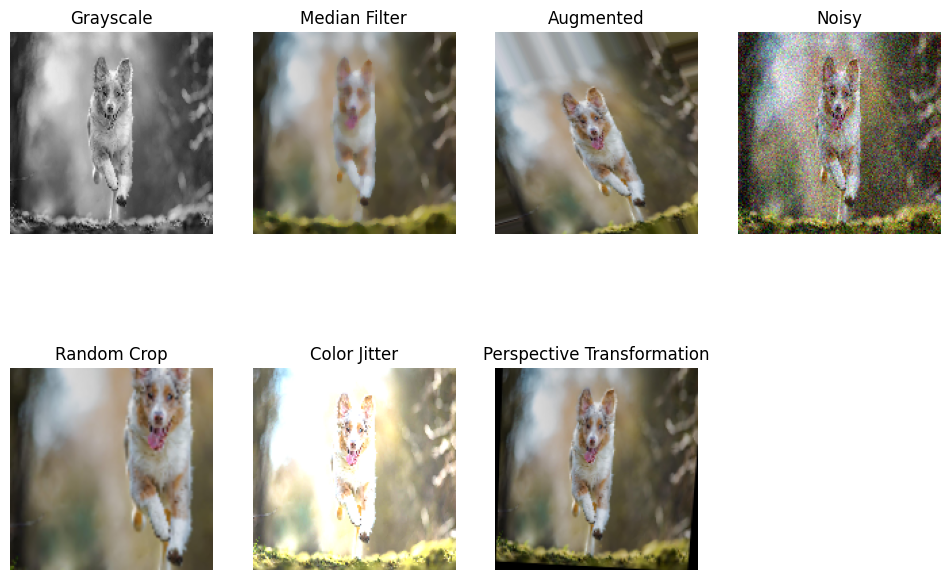

In [77]:
# Ensure the image is in the right format (float32 and in range [0, 1])
first_image_data = images_train[2].astype(np.float32)

# If the image data is normalized to [0, 1], convert it to [0, 255] and then to uint8 for certain operations
image_for_cv = (first_image_data * 255).astype(np.uint8)

# 1. Convert to Grayscale
gray_image = cv2.cvtColor(image_for_cv, cv2.COLOR_RGB2GRAY)

# 2. Apply Median Filter (requires uint8 if the kernel size is greater than 1)
filtered_image = cv2.medianBlur(image_for_cv, 5)

# 3. Augment Image - needs data in [0, 255] as uint8
augmented_image = augment_image(image_for_cv)  # Function will handle normalization internally if necessary

# 4. Add Noise - can operate on normalized float32 or uint8
noisy_image = add_noise(first_image_data)  # Assuming add_noise can handle float32 [0, 1]

# 5. Random Crop
cropped_image = random_crop(first_image_data, (100, 100))  # Assuming random_crop can handle float32 [0, 1]

# 6. Color Jitter - needs uint8 for the operation shown earlier
jittered_image = color_jitter(image_for_cv)  # Adjustments should handle uint8 [0, 255]

# 7. Perspective Transformation
perspective_image = perspective_transformation(first_image_data)  # Assuming perspective_transformation can handle float32 [0, 1]

# Displaying the images using Matplotlib - Convert all to float32 [0, 1] for consistent display
plt.figure(figsize=(12, 8))
plt.subplot(241); plt.imshow(gray_image, cmap='gray'); plt.title('Grayscale'); plt.axis('off')
plt.subplot(242); plt.imshow(filtered_image, cmap='gray'); plt.title('Median Filter'); plt.axis('off')
plt.subplot(243); plt.imshow(augmented_image); plt.title('Augmented'); plt.axis('off')
plt.subplot(244); plt.imshow(noisy_image); plt.title('Noisy'); plt.axis('off')
plt.subplot(245); plt.imshow(cropped_image); plt.title('Random Crop'); plt.axis('off')
plt.subplot(246); plt.imshow(jittered_image); plt.title('Color Jitter'); plt.axis('off')
plt.subplot(247); plt.imshow(perspective_image); plt.title('Perspective Transformation'); plt.axis('off')
plt.show()
